# Darcy Equation

## Preliminary steps

Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train-test split

In [2]:
def get_data(filename, ndata, r):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29 - basically r selects the course-grainedness, r=1 means no course-graining
    r = r
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = scipy.io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x[0], y, grid

r = 15
s = int(((421 - 1) / r) + 1)

x_train, y_train, train_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth1.mat", 1000, r)
x_test, y_test, test_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth2.mat", 1000, r)

visualise input/output data

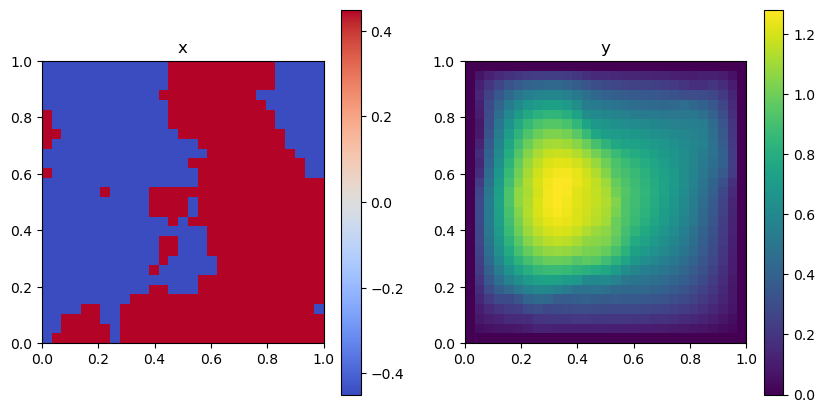

In [4]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

## Model definition

In [5]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = np.ones(self.n)
        else:
            ls = 1.0

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)
        
        train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        for i in range(n_samples):
            train_samples_pca_i = train_samples_pca[:, :, i]
            train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
            train_samples[:, :, i] = train_samples_i


        if n_samples is not None:
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca = np.stack(y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(y_pred_pca)

        test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))

        for i in range(n_samples):
            test_samples_pca_i = test_samples_pca[:, :, i]
            test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
            test_samples[:, :, i] = test_samples_i

        if n_samples is not None:
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

## Train

In [6]:
n_samples = 8

model = full_model(n = 5, m = 5, ARD = False, multiinput = True, standardise = False)
train_samples = model.fit(x_train, y_train, n_samples = n_samples)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  likelihood = likel

         Current function value: 921.115051
         Iterations: 25
         Function evaluations: 99
         Gradient evaluations: 88
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.9999933, dtype=float32), variance=Array(1.4364159, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.45162427, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 20%|██        | 1/5 [00:12<00:48, 12.02s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to

         Current function value: 958.229370
         Iterations: 24
         Function evaluations: 101
         Gradient evaluations: 90
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.9999895, dtype=float32), variance=Array(1.5471493, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.4686718, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 40%|████      | 2/5 [00:22<00:33, 11.05s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to

         Current function value: 1635.009521
         Iterations: 14
         Function evaluations: 109
         Gradient evaluations: 97
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(3.2460566, dtype=float32), variance=Array(1.4829704, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.9411305, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 60%|██████    | 3/5 [00:30<00:19,  9.73s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to

         Current function value: 317.670013
         Iterations: 30
         Function evaluations: 168
         Gradient evaluations: 156
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.999999, dtype=float32), variance=Array(0.5305722, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.23772731, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 80%|████████  | 4/5 [00:45<00:11, 11.65s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to

         Current function value: 400.662628
         Iterations: 25
         Function evaluations: 159
         Gradient evaluations: 147
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.9999976, dtype=float32), variance=Array(0.39961633, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.27875865, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 5/5 [00:56<00:00, 11.30s/it]


## Assess performance on training data

  0%|          | 0/5 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


median relative L2 (train data): 0.08857883512973785
mean relative L2 (train data): 0.09461842477321625


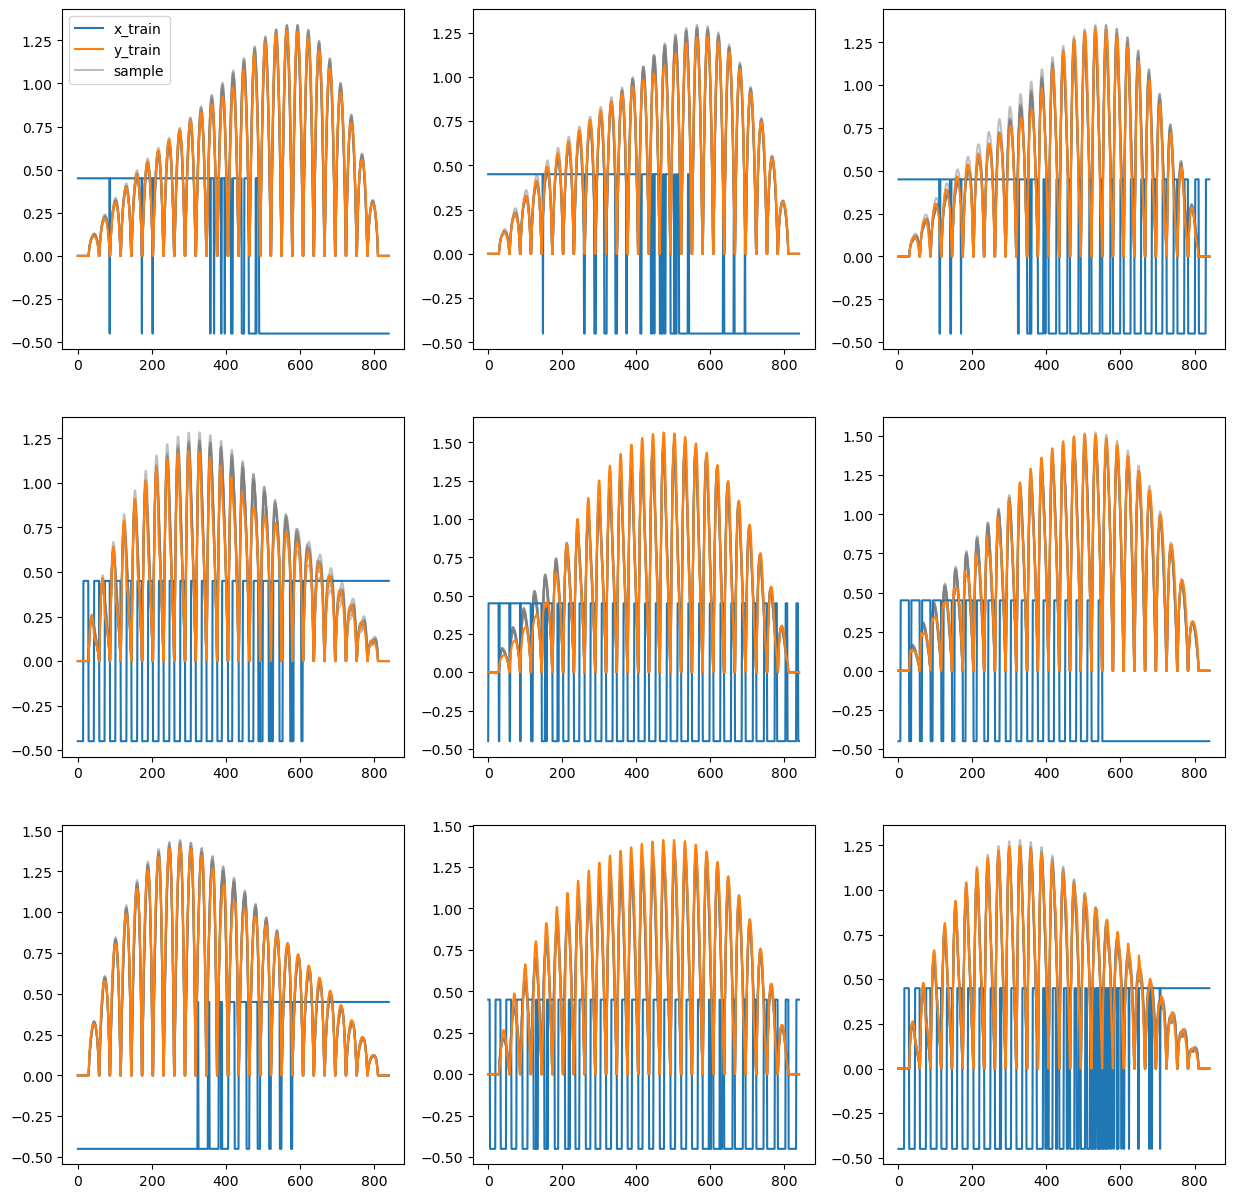

In [8]:
n_samples = 8

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(x_train[i], label='x_train')
    ax[i].plot(y_train[i], label='y_train')
    for j in range(n_samples):
        ax[i].plot(train_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()

## Test

  0%|          | 0/5 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


median relative L2: 0.1020023301243782
mean relative L2: 0.11128190159797668


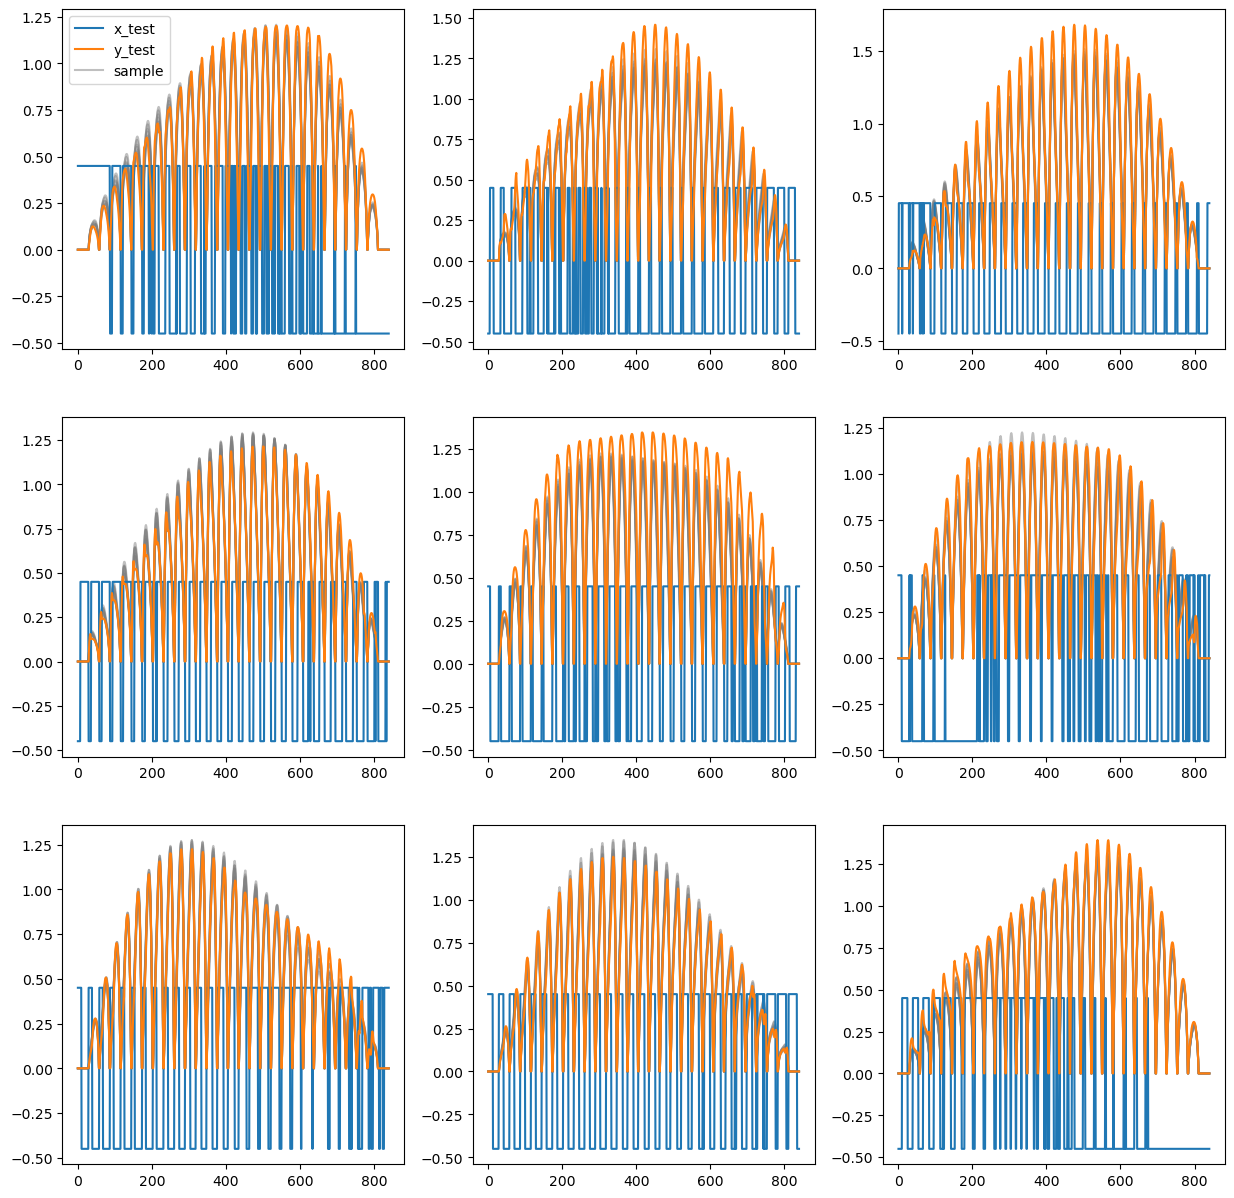

In [9]:
n_samples = 8

y_pred, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(x_test[i], label='x_test')
    ax[i].plot(y_test[i], label='y_test')
    for j in range(n_samples):
        ax[i].plot(test_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()